### Python imports

In [ ]:
import xarray as xr
import os
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from time import sleep
from functools import partial
import time
import numcodecs
import zarr
import dask
import io
import boto3
from dask.distributed import as_completed
import s3fs
import dask.array as da

### Inputs

In [2]:
def read_dataset_inmemory(s3_path: str) -> xr.Dataset:
    """Read a NetCDF as an XArray using in-memory data"""
    try:
        with io.BytesIO() as inmemoryfile:
            # Use boto to download a file to memory
            # session = boto3.Session(profile_name='nonproduction-admin')
            s3 = boto3.client('s3')
            bucket, key = s3_path.replace("s3://", "").split("/", 1)
            s3.download_fileobj(bucket, key, inmemoryfile)
            inmemoryfile.seek(0)
            return xr.open_dataset(inmemoryfile)
    except ValueError as e:
        print(f"Failed to open the file with error: {e}")
        return None

### Argo Processor

**Source notebook**
https://medium.com/@nicolasmortimer/argo-floats-zarr-and-pangeo-d74fc6d4ce35

*Written by Nicolas Mortimer*

In [3]:
data_types ={'CONFIG_MISSION_NUMBER':'float32','CYCLE_NUMBER':'float32','DATA_CENTRE':'|U2','DATA_MODE':'|U1',
             'DATA_STATE_INDICATOR':'|U4','DC_REFERENCE':'|U32','DIRECTION':'|U1','FIRMWARE_VERSION':'|U32',
             'FLOAT_SERIAL_NO':'|U32','JULD':'float32','JULD_LOCATION':'float32','JULD_QC':'|U1','LATITUDE':'float32',
             'LONGITUDE':'float32','PI_NAME':'|U64','PLATFORM_NUMBER':'|U8','PLATFORM_TYPE':'|U32','POSITIONING_SYSTEM':'|U8',
             'POSITION_QC':'|U1','PRES':'float32','PRES_ADJUSTED':'float32','PRES_ADJUSTED_ERROR':'float32',
             'PRES_ADJUSTED_QC':'|U1','PRES_QC':'|U1','PROFILE_PRES_QC':'|U1','PROFILE_PSAL_QC':'|U1','PROFILE_TEMP_QC':'|U1',
             'PROJECT_NAME':'|U64','PSAL':'float32','PSAL_ADJUSTED':'float32','PSAL_ADJUSTED_ERROR':'float32',
             'PSAL_ADJUSTED_QC':'|U1','PSAL_QC':'|U1','TEMP':'float32','TEMP_ADJUSTED':'float32','TEMP_ADJUSTED_ERROR':'float32',
             'TEMP_ADJUSTED_QC':'|U1','TEMP_QC':'|U1','VERTICAL_SAMPLING_SCHEME':'|U256','WMO_INST_TYPE':'|U4'}

data_levels =['PRES','PRES_ADJUSTED','PRES_ADJUSTED_ERROR','PRES_ADJUSTED_QC','PRES_QC','PSAL','PSAL_ADJUSTED',
              'PSAL_ADJUSTED_ERROR','PSAL_ADJUSTED_QC','PSAL_QC','TEMP','TEMP_ADJUSTED','TEMP_ADJUSTED_ERROR',
              'TEMP_ADJUSTED_QC','TEMP_QC']

def process_mf(dsinput,levels,data_types=data_types,data_levels=data_levels):
    ds = xr.Dataset()
    dims =('N_PROF','N_LEVELS')
    # The number of profiles is indicated by the N_PROF dimension
    # The number of pressure levels is indicated by the N_LEVELS dimension
    pading =xr.DataArray(np.ones((len(dsinput.N_PROF),levels-len( dsinput.N_LEVELS))) *np.nan,dims=dims)
    pad_qc = xr.DataArray(np.chararray((len(dsinput.N_PROF),levels-len( dsinput.N_LEVELS))),dims=dims)
    pad_qc[:] = b' '
    for varname in data_types.keys():
        if varname in dsinput.data_vars:
            da = dsinput[varname]
            if 'N_LEVELS' in da.dims:   
                if varname in dsinput.data_vars:
                    if varname.endswith('QC'):
                        da = xr.concat([dsinput[varname],pad_qc],dim='N_LEVELS').astype(data_types[varname])
                    else:
                        da = xr.concat([dsinput[varname],pading],dim='N_LEVELS').astype(data_types[varname])
            else:
                da = dsinput[varname].astype(data_types[varname])
        else:
            if varname in data_levels:
                if data_types[varname]=='float32':
                    da = xr.DataArray(np.ones((len(dsinput.N_PROF),levels), dtype='float32')*np.nan , name=varname, dims=['N_PROF','N_LEVELS'])
                else:
                    p=np.chararray((len(dsinput.N_PROF),levels))
                    p[:]=b'0'
                    da = xr.DataArray(p.astype(data_types[varname]), name=varname, dims=['N_PROF','N_LEVELS'])
            else:
                if data_types[varname]=='float32':
                    da = xr.DataArray(np.ones(len(dsinput.N_PROF), dtype="float32")*np.nan , name=varname, dims=['N_PROF'])
                else:
                    p=np.chararray((len(dsinput.N_PROF)))
                    p[:]=b'0'
                    da = xr.DataArray(p.astype(data_types[varname]), name=varname, dims=['N_PROF'])
        if not ('HISTORY' in varname) and ('N_CALIB' not in da.dims) and ('N_PARAM' not in da.dims) and  ('N_PROF' in da.dims):
                ds[varname]= da
    return ds.chunk({'N_LEVELS':levels})

In [4]:
def process_float(s3_uri):
    preproc = partial(process_mf,levels=3000)
    file = read_dataset_inmemory(s3_uri)
    data = preproc(file)
    return data

In [5]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

### Generate dataset and export to Zarr

Paths and store declaration

In [6]:
# %%time
# Not available to the public this section
# s3 = s3fs.S3FileSystem(anon=False)
# source_path = 'S3 uri to NetCDF files source'
# glob_result = s3.glob(source_path)
# output_name = 'argo-test'
# store_path = f'S3 uri of the destination'
# store = s3fs.S3Map(root=f'{store_path}', s3=s3, check=False)
# input_paths = []
# input_paths.extend(['s3://' + path for path in glob_result])
# all_chunked_paths = list(chunks(input_paths, 500))

### Using Dask

#### Local cluster

#### Dask extension local cluster

In [9]:
# import dask
# from dask.distributed import Client, LocalCluster

# dask_user = 'ec2-user'
# dask_address = 'localhost'
# dask_port = '0'

# with dask.config.set({'temporary_directory': f'/home/{dask_user}/dask/'}):
#     # set up cluster and workers
#     cluster = LocalCluster(n_workers=4, memory_limit='4GB', processes=True, 
#                            threads_per_worker=4, dashboard_address=f':{dask_port}', ip=dask_address)
#     client = Client(address=cluster.scheduler_address)

# print(f'http://{dask_address}'+':{port}/status'.format(port=client.scheduler_info().get('services').get('dashboard')))

In [10]:
# # Core logic only
# start_time = time.time()
# print('************** Processing **************')
# for i in tqdm(range(len(all_chunked_paths))):
#     overwrite = True if i == 0 else False
#     futures = []
#     for path in all_chunked_paths[i]:
#         futures.append(client.submit(process_float, path, retries=10))
#     zarrs = client.gather(futures)
#     ds = xr.concat(zarrs, dim='N_PROF', coords='minimal',compat='override',combine_attrs='override', fill_value='')
#     chunked = ds.chunk(chunks={'N_PROF': 500, 'N_LEVELS': 800})
#     for var in chunked.data_vars:
#         chunked[var].encoding = {}
#     if overwrite:
#         z = chunked.to_zarr(store, mode='w', consolidated=True, compute=False) # return delayed obj
#     else:
#         z = chunked.to_zarr(store, mode='a', append_dim='N_PROF', consolidated=True, compute=False)
#     z.compute() 
# print('*********************************************')
# print("---------- Total: %.2f seconds ----------" % (time.time() - start_time))
# print('*********************************************')

In [11]:
# client.close()
# cluster.close()

### Open Zarr and Visualisation

In [12]:
import matplotlib.pyplot as plt
from datetime import datetime

def np_dt64_to_dt(in_datetime: np.datetime64) -> str:
    """Convert numpy datetime64 to datetime"""
    dt = datetime.fromtimestamp(in_datetime.astype(int) / 1e9)
    return dt.strftime("%Y-%m-%dT%H:%M:%SZ")

In [13]:
%%time
store_path = 's3://imos-data-pixeldrill/csiro-argo.zarr/'
data = xr.open_zarr(store_path)
data

CPU times: user 315 ms, sys: 17.9 ms, total: 333 ms
Wall time: 819 ms


<xarray.Dataset>
Dimensions:                   (N_PROF: 254787, N_LEVELS: 3000)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables: (12/40)
    CONFIG_MISSION_NUMBER     (N_PROF) float32 dask.array<chunksize=(500,), meta=np.ndarray>
    CYCLE_NUMBER              (N_PROF) float32 dask.array<chunksize=(500,), meta=np.ndarray>
    DATA_CENTRE               (N_PROF) <U2 dask.array<chunksize=(500,), meta=np.ndarray>
    DATA_MODE                 (N_PROF) <U1 dask.array<chunksize=(500,), meta=np.ndarray>
    DATA_STATE_INDICATOR      (N_PROF) <U4 dask.array<chunksize=(500,), meta=np.ndarray>
    DC_REFERENCE              (N_PROF) <U32 dask.array<chunksize=(500,), meta=np.ndarray>
    ...                        ...
    TEMP_ADJUSTED             (N_PROF, N_LEVELS) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    TEMP_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    TEMP_ADJUSTED_QC          (N_PROF, N_LEVELS) <U1 dask.array<chunksize=(500, 800), meta=np.ndarray>
    TEMP_QC                   (N_PROF, N_LEVELS) <U1 dask.array<chunksize=(500, 800), meta=np.ndarray>
    VERTICAL_SAMPLING_SCHEME  (N_PROF) <U256 dask.array<chunksize=(500,), meta=np.ndarray>
    WMO_INST_TYPE             (N_PROF) <U4 dask.array<chunksize=(500,), meta=np.ndarray>

In [14]:
data.TEMP_ADJUSTED

<xarray.DataArray 'TEMP_ADJUSTED' (N_PROF: 254787, N_LEVELS: 3000)>
dask.array<open_dataset-6ee6c57e39d0eee17a7f2a693719ccd5TEMP_ADJUSTED, shape=(254787, 3000), dtype=float32, chunksize=(500, 800), chunktype=numpy.ndarray>
Dimensions without coordinates: N_PROF, N_LEVELS
Attributes:
    C_format:        %9.3f
    FORTRAN_format:  F9.3
    long_name:       Sea temperature in-situ ITS-90 scale
    resolution:      0.0010000000474974513
    standard_name:   sea_water_temperature
    units:           degree_Celsius
    valid_max:       40.0
    valid_min:       -2.5

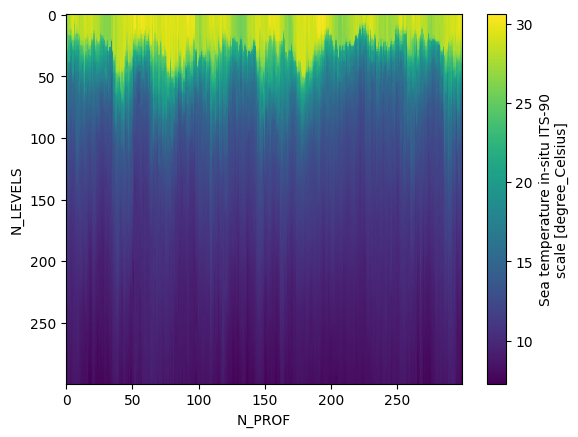

In [15]:
# Quick Timeseries Profile plot of Temperature
data.isel(N_PROF=slice(18200, 18500), N_LEVELS=slice(0,300)).TEMP_ADJUSTED.plot(x='N_PROF')
plt.gca().invert_yaxis()

In [16]:
# Profile Plot
nprof = 0 #Specify a profile to plot

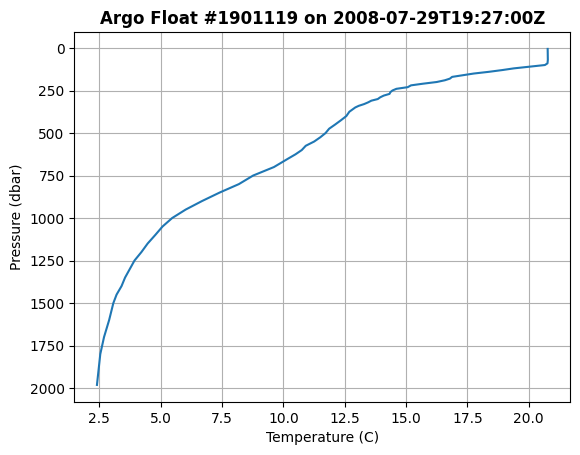

CPU times: user 341 ms, sys: 102 ms, total: 444 ms
Wall time: 476 ms


In [17]:
%%time
plt.plot(data.TEMP_ADJUSTED[nprof], data.PRES_ADJUSTED[nprof])
plt.xlabel('Temperature (C)')
plt.ylabel('Pressure (dbar)')
plt.grid()
plt.title('Argo Float #%d on %s' % (data.PLATFORM_NUMBER[nprof].values, np_dt64_to_dt(data.JULD[nprof].values)), fontweight='bold');
plt.gca().invert_yaxis() #Flip the y-axis
plt.show()

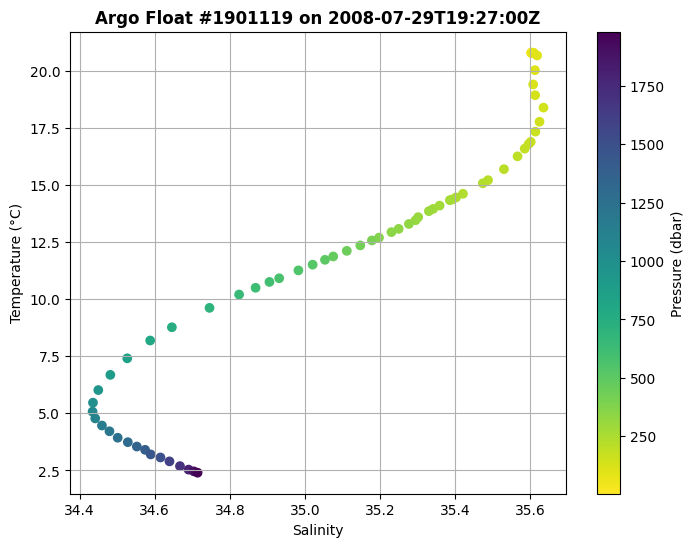

CPU times: user 527 ms, sys: 68 ms, total: 595 ms
Wall time: 566 ms


In [18]:
%%time
plt.figure(figsize=(8,6))
plt.scatter(data.PSAL_ADJUSTED[nprof], data.TEMP_ADJUSTED[nprof], c=data.PRES_ADJUSTED[nprof], cmap='viridis_r')
plt.xlabel('Salinity');
plt.ylabel('Temperature (°C)')
cbh = plt.colorbar();
cbh.set_label('Pressure (dbar)')
plt.grid()
plt.title('Argo Float #%d on %s' % (data.PLATFORM_NUMBER[nprof].values, np_dt64_to_dt(data.JULD[nprof].values)), fontweight='bold');
plt.show()

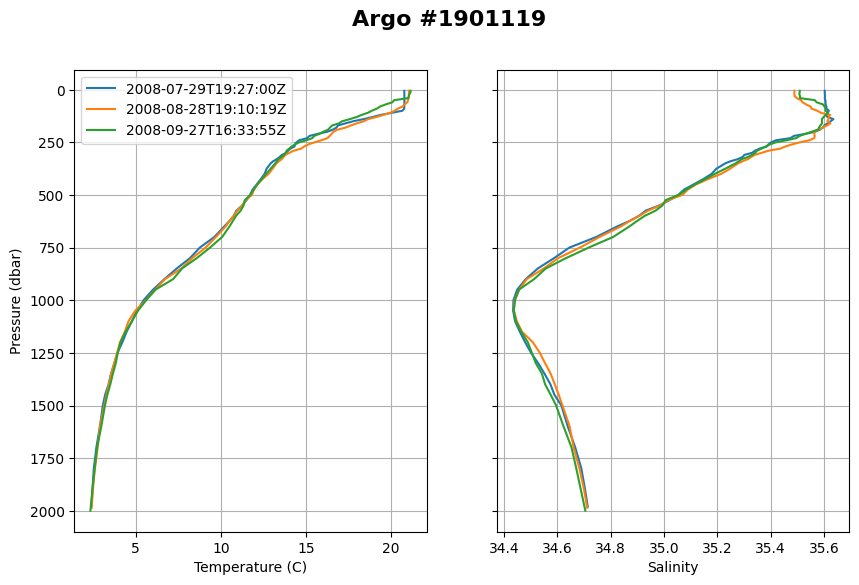

CPU times: user 592 ms, sys: 124 ms, total: 717 ms
Wall time: 783 ms


In [19]:
%%time
# Profile Plot
# Subplot example
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(10,6))
nprof = 0 # First profile
ax1.plot(data.TEMP_ADJUSTED[nprof], data.PRES_ADJUSTED[nprof], label=np_dt64_to_dt(data.JULD[nprof].values))
ax2.plot(data.PSAL_ADJUSTED[nprof], data.PRES_ADJUSTED[nprof])
nprof_mid = nprof + 3
ax1.plot(data.TEMP_ADJUSTED[nprof_mid], data.PRES_ADJUSTED[nprof_mid], label=np_dt64_to_dt(data.JULD[nprof_mid].values))
ax2.plot(data.PSAL_ADJUSTED[nprof_mid], data.PRES_ADJUSTED[nprof_mid])
nprof_last = nprof_mid + 3 # Last profile
ax1.plot(data.TEMP_ADJUSTED[nprof_last], data.PRES_ADJUSTED[nprof_last], label=np_dt64_to_dt(data.JULD[nprof_last].values))
ax2.plot(data.PSAL_ADJUSTED[nprof_last], data.PRES_ADJUSTED[nprof_last])
ax1.set_ylabel('Pressure (dbar)')
ax1.set_xlabel('Temperature (C)')
ax2.set_xlabel('Salinity')
ax1.invert_yaxis()
ax1.legend()
# Add some gridlines
ax1.grid()
ax2.grid()
# Add a super title
fig.suptitle('Argo #%d' % data.PLATFORM_NUMBER[nprof].values, fontweight='bold', fontsize=16)
plt.show()

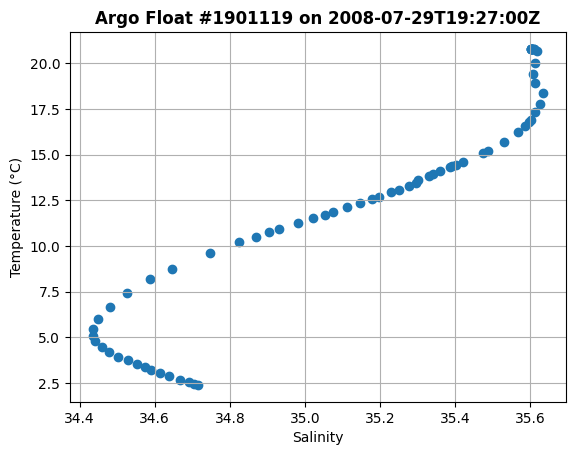

CPU times: user 393 ms, sys: 101 ms, total: 495 ms
Wall time: 460 ms


In [20]:
%%time
plt.scatter(data.PSAL_ADJUSTED[nprof], data.TEMP_ADJUSTED[nprof])
plt.xlabel('Salinity')
plt.ylabel('Temperature (°C)')
plt.grid()
plt.title('Argo Float #%d on %s' % (data.PLATFORM_NUMBER[nprof].values, np_dt64_to_dt(data.JULD[nprof].values)), fontweight='bold')
plt.show()

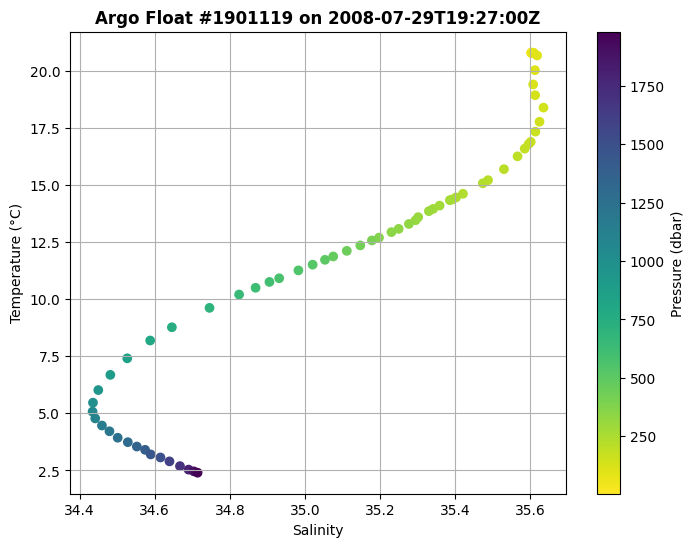

CPU times: user 579 ms, sys: 97 ms, total: 676 ms
Wall time: 642 ms


In [21]:
%%time
plt.figure(figsize=(8,6))
plt.scatter(data.PSAL_ADJUSTED[nprof], data.TEMP_ADJUSTED[nprof], c=data.PRES_ADJUSTED[nprof], cmap='viridis_r')
plt.xlabel('Salinity');
plt.ylabel('Temperature (°C)')
cbh = plt.colorbar();
cbh.set_label('Pressure (dbar)')
plt.grid()
plt.title('Argo Float #%d on %s' % (data.PLATFORM_NUMBER[nprof].values, np_dt64_to_dt(data.JULD[nprof].values)), fontweight='bold')
plt.show()